In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from model_settings import ms
from df_collector import df_collector
pd.set_option("display.max_columns",0)
pd.options.display.float_format = '{:.6f}'.format
root = Path().resolve().parent.parent
df_collector.root = root
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}")


##################
# training start #
##################

Fri Nov  8 16:31:02 2024


In [2]:
data = df_collector.cboe_spx_barriers().iloc[:,1:]
pricename = [f for f in data.columns if f.find('_price')!=-1 and f.find('spot_')==-1 and f.find('strike_')==-1][0]
data = data[data[pricename]<=data['spot_price']]
print(f'collected {pricename[:pricename.find('_',0)]} options')
print(data.describe())

collected barrier options
          spot_price   strike_price        barrier  days_to_maturity         rebate  dividend_rate  risk_free_rate          theta          kappa            rho            eta             v0  barrier_price
count 1894421.000000 1894421.000000 1894421.000000    1894421.000000 1894421.000000 1894421.000000  1894421.000000 1894421.000000 1894421.000000 1894421.000000 1894421.000000 1894421.000000 1894421.000000
mean     3853.532157    3853.549032    3867.391663        323.163642       0.000000       0.016549        0.024114       0.127763       5.833853      -0.799645       2.004978       0.061885     181.915627
std       820.167307     858.710767    1464.325332        240.829261       0.000000       0.002454        0.019437       0.187295       9.167321       0.163912       2.140103       0.092540     333.583720
min      2389.000000    2150.100000    1194.500000         60.000000       0.000000       0.012624        0.000330       0.000000       0.000000      -1.0

In [3]:
filetag = f'cboe spx relative {pricename[:pricename.find('_',0)]}'

In [4]:
data[pricename].describe()

count   1894421.000000
mean        181.915627
std         333.583720
min           0.000000
25%           1.681408
50%          52.287167
75%         233.659817
max        5424.825644
Name: barrier_price, dtype: float64

In [5]:
lower_price_tolerance = 0.00001
data = data[data[pricename]>=lower_price_tolerance].copy()
data[pricename].describe()

count   1672026.000000
mean        206.112097
std         347.982672
min           0.000010
25%          10.674980
50%          80.110259
75%         265.964294
max        5424.825644
Name: barrier_price, dtype: float64

In [6]:
peturbations = pd.Series(np.random.normal(scale=lower_price_tolerance*0.18,size=data.shape[0]),name='peturbations')
peturbations.describe()

count   1672026.000000
mean          0.000000
std           0.000002
min          -0.000009
25%          -0.000001
50%           0.000000
75%           0.000001
max           0.000008
Name: peturbations, dtype: float64

In [7]:
data['observed_price'] = data[pricename].values+peturbations
data['observed_price'].describe()

count   1401404.000000
mean        205.375379
std         343.906774
min           0.000004
25%          10.757674
50%          80.435002
75%         266.571608
max        5424.825643
Name: observed_price, dtype: float64

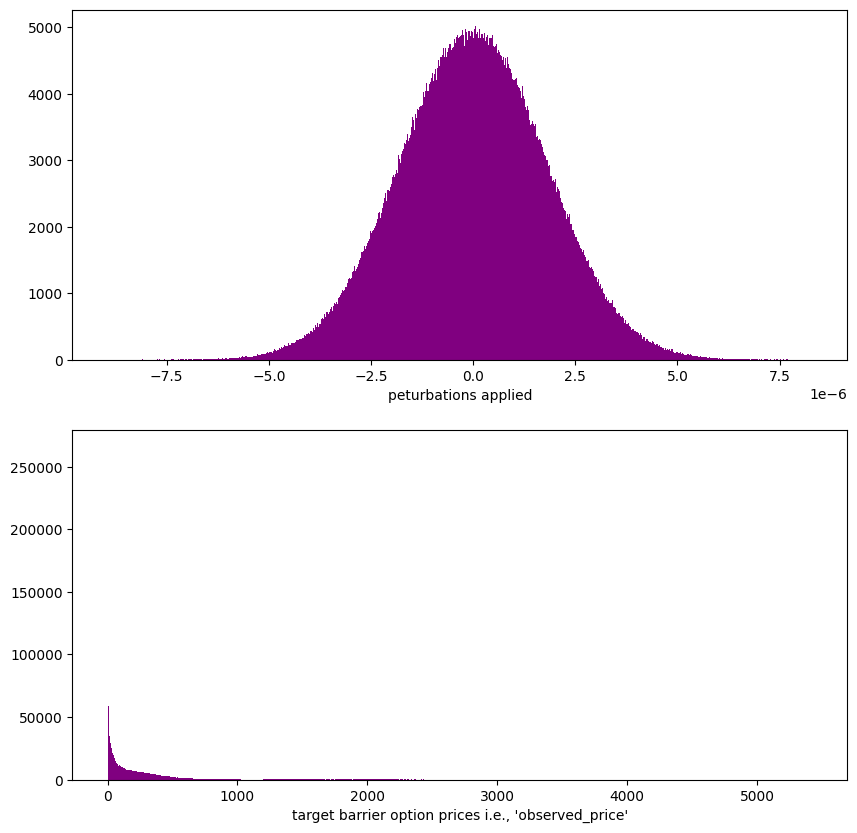

total data count: 1672026
count   1401404.000000
mean        205.375379
std         343.906774
min           0.000004
25%          10.757674
50%          80.435002
75%         266.571608
max        5424.825643
Name: observed_price, dtype: float64


In [8]:
plotprices = data['observed_price']
"""
plot
"""
fig,axs = plt.subplots(2,figsize=(10,10))
axs[0].hist(peturbations,bins=int(len(peturbations)**0.5),color='purple')
axs[0].set_xlabel('peturbations applied')
axs[1].hist(plotprices,bins=int(len(plotprices)**0.5),color='purple')
axs[1].set_xlabel(f"target {pricename[:pricename.find('_')]} option prices i.e., 'observed_price'")
plt.show()
print(f"total data count: {data.shape[0]}")
print(data['observed_price'].describe())

Help on function PlotCols in module plotters.PlotCols:

PlotCols(df, col_names=None, index=None, figsize=(10, 15), exclusions=None)
    index parameter currently supports only pandas timestamps

['spot_price', 'v0']


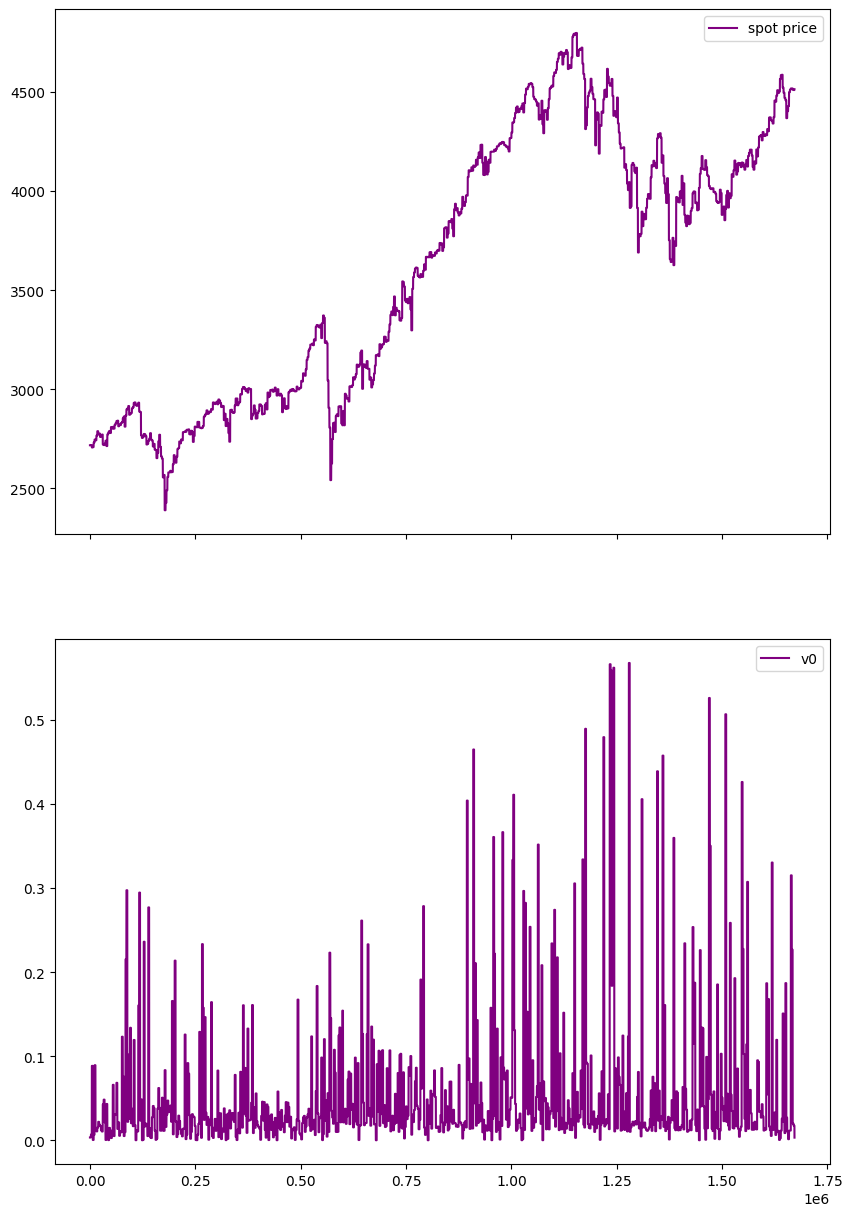

In [17]:
from plotters import PlotCols
help(PlotCols)
PlotCols(data[['calculation_date','spot_price','v0']],col_names=['spot_price','v0'],index='calculation_date')

In [9]:
data_strikes = data['strike_price']
data['relative_spot'] = data['spot_price']/data_strikes
data['relative_observed'] = data['observed_price']/data_strikes
try:
    data['relative_barrier'] = data['barrier']/data_strikes
    data['relative_rebate'] = data['rebate']/data_strikes
except Exception:
    pass
data = data[data['relative_observed']>0.001].copy()

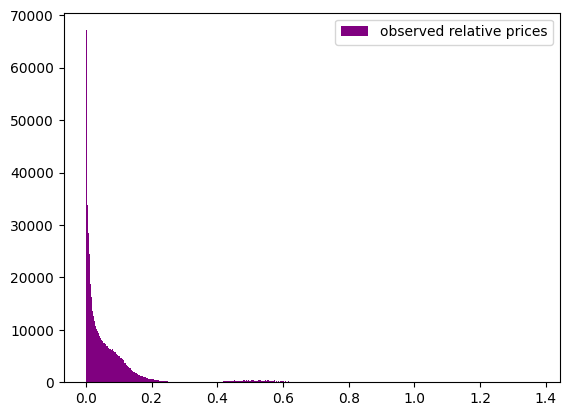

count   1147177.000000
mean          0.071248
std           0.107239
min           0.001000
25%           0.010710
50%           0.037473
75%           0.088572
max           1.373277
Name: relative_observed, dtype: float64

In [10]:
"""
plot
"""
rels = data['relative_observed']
plt.figure()
plt.hist(rels,color='purple',label='observed relative prices',bins=int(np.sqrt(len(rels))))
plt.legend()
plt.show()
rels.describe()

# training procedure

In [11]:
from convsklearn import convsklearn
trainer = convsklearn()
trainer.target_name = 'relative_observed'
trainer.excluded_features = trainer.excluded_features + ['spot_price','strike_price','barrier','rebate','relative_observed']
trainer.__dict__

{'seed': 1312,
 'raw_data': Empty DataFrame
 Columns: []
 Index: [],
 'dataset': Empty DataFrame
 Columns: []
 Index: [],
 'target_name': 'relative_observed',
 'excluded_features': ['barrier_price',
  'asian_price',
  'observed_price',
  'outin',
  'updown',
  'n_fixings',
  'spot_price',
  'strike_price',
  'barrier',
  'rebate',
  'relative_observed'],
 'numerical_features': [],
 'categorical_features': [],
 'feature_set': [],
 'n_features': 0,
 'development_dates': {},
 'test_dates': {},
 'train_data': {},
 'test_data': {},
 'train_X': {},
 'train_y': {},
 'test_X': {},
 'test_y': {},
 'preprocessor': None,
 'pipeline': None,
 'model': None,
 'model_fit': None,
 'dnn_runtime': 0,
 'numerical_scaler': StandardScaler()}

In [12]:
trainer.load_data(data)
print('features:')
for f in trainer.feature_set:
    print(f"   {f}")
print(f"\ntarget:\n   {trainer.target_name}")

features:
   days_to_maturity
   dividend_rate
   risk_free_rate
   theta
   kappa
   rho
   eta
   v0
   relative_spot
   relative_barrier
   relative_rebate
   w
   barrier_type_name

target:
   relative_observed


## preprocessing

In [13]:
dates = pd.Series(np.sort(data['date'].unique()))
# i = round(len(dates)//100,0)*100
# dates = dates[-i:].reset_index(drop=True).copy()
dates

0      2018-05-30
1      2018-05-31
2      2018-06-01
3      2018-06-04
4      2018-06-05
          ...    
576    2023-08-29
577    2023-08-30
578    2023-08-31
579    2023-09-01
580    2023-09-05
Length: 581, dtype: object

In [14]:
stop yo

SyntaxError: invalid syntax (616740101.py, line 1)

In [ ]:
development_dates = dates[:len(dates)//3]
test_dates = dates[~dates.isin(development_dates)]
trainer.preprocess_data(development_dates,test_dates)

## training

In [ ]:
trainer.run_dnn()

In [ ]:
print('instance variables:')

for key, value in trainer.__dict__.items():
    print(f"{key}:\n  {value}\n")

### initial test

In [ ]:
train_test = trainer.test_prediction_accuracy()

In [ ]:
oserr = trainer.test_data['outofsample_error']
iserr = trainer.train_data['insample_error']

In [ ]:
plt.figure()
plt.hist(oserr,color='purple',label='out-of-sample',bins=int(np.sqrt(len(oserr))))
plt.hist(iserr,color='green',label='in-sample',bins=int(np.sqrt(len(iserr))))
plt.legend()
plt.title('distributions of prediction error')
plt.show()

## saving

In [ ]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    joblib.dump(trainer.__dict__,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

In [ ]:
save_model()